In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
raw_data = pd.read_csv('../data/Index2018.csv')

In [3]:
raw_data.head()

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


In [4]:
raw_data.tail()

,date,spx,dax,ftse,nikkei
6264,23/01/2018,2839.130362,13559.60,7731.827774,24124.15
6265,24/01/2018,2837.544008,13414.74,7643.428966,23940.78
6266,25/01/2018,2839.253031,13298.36,7615.839954,23669.49
6267,26/01/2018,2872.867839,13340.17,7665.541292,23631.88
6268,29/01/2018,2853.528411,13324.48,7671.533300,23629.34


In [5]:
df_comp = raw_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, dayfirst=True)
df_comp.drop(['dax', 'ftse', 'nikkei'], axis=1, inplace=True)
df_comp.rename(columns={'spx': 'market_value'}, inplace=True)
df_comp.set_index('date', inplace=True)

size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size].copy(), df_comp.iloc[size:].copy()

In [6]:
df.tail()

,market_value
date,
2013-03-28,1569.185872
2013-03-29,1569.185872
2013-04-01,1562.173837
2013-04-02,1570.252238
2013-04-03,1553.686978


# White Noise

White noise is a series of random data that has no pattern. Because it has no pattern, we cannot predict the future. White noise has three conditions: 1) constant mean, 2) constant variation, and 3) no autocorrelation.

Let's create a white noise time-series data that has the same mean and std as the S&P closing price. If the data resembles white noise, we will not try to predict. 

In [7]:
# random value from normal distribution
wn = np.random.normal(df_comp.market_value.mean(), df_comp.market_value.std(), len(df)) 
df.loc[:, 'wn'] = wn

In [8]:
# means are similar but different because np.random.normal generates values individually
df.describe()

,market_value,wn
count,5015.000000,5015.000000
mean,1091.357559,1296.238117
std,292.487977,496.266096
min,438.920000,-719.881733
25%,914.608917,954.636143
50%,1144.581490,1296.748677
75%,1315.996495,1632.135399
max,1570.252238,3092.868840


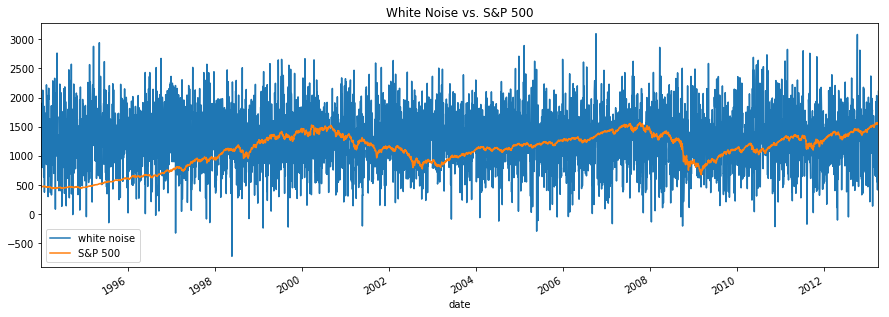

In [9]:
fig, ax = plt.subplots(figsize=(15, 5))
df.wn.plot()
df.market_value.plot()

plt.title("White Noise vs. S&P 500")
plt.legend(['white noise', 'S&P 500'])
plt.show()

# Random Walk

Random Walk is a type of time series where difference between two consecutive periods are simply White Noise. 


$$
P_t = P_{t-1} + \epsilon_t
$$

where $P_t = \text{prices}$, 
$\epsilon_t = \text{residuals}$

Also, residuals are White Noise. 
$$\epsilon_t \sim WN(\mu, \sigma^2)$$


In Random Walk, the best predictor of tomorrow is today's data and we cannot predict the further future with great accuracy. 

In [10]:
# pre-genenarted random walk data
rw = pd.read_csv('../data/RandWalk.csv')
rw.date = pd.to_datetime(rw.date, dayfirst=True)
rw.set_index('date', inplace=True)
rw = rw.asfreq('b')

In [11]:
df['rw'] = rw.price

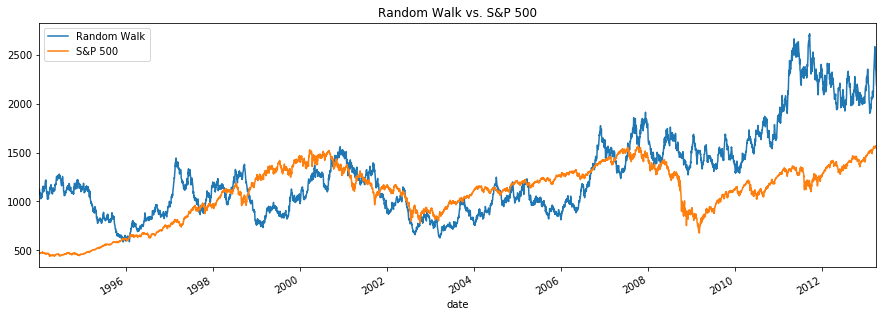

In [12]:
# plt.plot(rw)
fig, ax = plt.subplots(figsize=(15, 5))
df.rw.plot()
df.market_value.plot()

plt.title("Random Walk vs. S&P 500")
plt.legend(['Random Walk', 'S&P 500'])
plt.show()

S&P data looks much like random walk than white noise. 
- Small variation between consecutive time periods
- Both have cyclical increases and decreases in short periods of time 

# Stationarity